In [46]:
import numpy as np
import pandas as pd
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns


In [27]:
PATH_ART = "/kaggle/input/articles-classification/Art.csv"
PATH_ECONOMY = "/kaggle/input/articles-classification/Economy.csv"
PATH_SPORT = "/kaggle/input/articles-classification/Sports.csv"

In [28]:
df_art = pd.read_csv(PATH_ART)
df_economy = pd.read_csv(PATH_ECONOMY)
df_sport = pd.read_csv(PATH_SPORT)

In [29]:
display(df_art.head())
display(df_economy.head())
display(df_sport.head())

,Unnamed: 0,Article Title,Category
0,0,\n\nWorks by Picasso and others stolen in Spai...,Art
1,1,\n\nSalwa and Maged at the Art Corner Gallery ...,Art
2,2,\n\nA tribute to Abdalla Gohar\n\n\n\nOn 1 Dec...,Art
3,3,"\n\nRaw, untamed, and compelling: ‘Flesh’ by S...",Art
4,4,\n\nFrom water to mosaics\n\n\n\nThe Gezira Ce...,Art


,Unnamed: 0,Article Title,Category
0,0,"\n\nChinese demand, Mideast turmoil boost ship...",economy
1,1,\n\nEgypt government to issue LE1 bn in zero c...,economy
2,2,\n\nFirst Egyptian Samsung factory starts prod...,economy
3,3,\n\nUPDATED: Egyptian and Arab stocks soar as ...,economy
4,4,\n\nGreek high school teachers to strike over ...,economy


,Unnamed: 0,Article Title,Category
0,0,\n\nFans in shock after Leicester City helicop...,sports
1,1,\n\nLeicester City football club owner was on ...,sports
2,2,\n\nLeicester City football club owner's helic...,sports
3,3,\n\nRonaldo scores twice as Juve overcome frig...,sports
4,4,\n\nKlopp hails Liverpool's '20-point win' ove...,sports


# 1: Pre-Processing

combines the art, economy, and sport dataframes into one and removes the unnecessary "Unnamed: 0" column.

In [30]:
df = pd.concat([df_art, df_economy, df_sport], axis=0, ignore_index=True)
df.drop(columns=["Unnamed: 0"], inplace=True)

In [31]:
df

,Article Title,Category
0,\n\nWorks by Picasso and others stolen in Spai...,Art
1,\n\nSalwa and Maged at the Art Corner Gallery ...,Art
2,\n\nA tribute to Abdalla Gohar\n\n\n\nOn 1 Dec...,Art
3,"\n\nRaw, untamed, and compelling: ‘Flesh’ by S...",Art
4,\n\nFrom water to mosaics\n\n\n\nThe Gezira Ce...,Art
...,...,...
30432,Germany Bundesliga results & scorers (21st mat...,sports
30433,Barcelona go fourth after winning six-goal thr...,sports
30434,Dortmund humiliated by Leverkusen in Haaland's...,sports
30435,"Back from injury, 1st Liverpool goal for teen ...",sports


defines a function to preprocess text data and applies it to the 'Article Title' column. It tokenizes the text, converts to lowercase, removes stopwords, and applies stemming.

In [32]:
stemmer = PorterStemmer()
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

df['processed_text'] = df['Article Title'].apply(preprocess_text)

In [33]:
df

,Article Title,Category,processed_text
0,\n\nWorks by Picasso and others stolen in Spai...,Art,"[work, picasso, other, stolen, spain, picasso,..."
1,\n\nSalwa and Maged at the Art Corner Gallery ...,Art,"[salwa, mage, art, corner, galleri, exhibit, p..."
2,\n\nA tribute to Abdalla Gohar\n\n\n\nOn 1 Dec...,Art,"[tribut, abdalla, gohar, decemb, khan, al, mag..."
3,"\n\nRaw, untamed, and compelling: ‘Flesh’ by S...",Art,"[raw, untam, compel, flesh, samir, fouad, crud..."
4,\n\nFrom water to mosaics\n\n\n\nThe Gezira Ce...,Art,"[water, mosaic, gezira, centr, modern, art, ex..."
...,...,...,...
30432,Germany Bundesliga results & scorers (21st mat...,sports,"[germani, bundesliga, result, scorer, matchday..."
30433,Barcelona go fourth after winning six-goal thr...,sports,"[barcelona, go, fourth, win, thriller, atletic..."
30434,Dortmund humiliated by Leverkusen in Haaland's...,sports,"[dortmund, humili, leverkusen, haaland, absenc..."
30435,"Back from injury, 1st Liverpool goal for teen ...",sports,"[back, injuri, liverpool, goal, teen, elliott,..."


In [34]:
df = df.drop('Article Title', axis=1)
df = shuffle(df)

X_train, X_test, y_train, y_test = train_test_split(df['processed_text'].apply(' '.join), df['Category'], test_size=0.2, random_state=42)

applies the TF-IDF vectorizer to the training and testing data to convert the text data into numerical features that can be used for machine learning.

In [35]:
# Use TF-IDF for word embedding
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# 2: The models(Naive bayes and SVM)

Convert the dataFrame to label encoding and train model on Naive bayse

In [36]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train_encoded)

nb_y_pred = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test_encoded, nb_y_pred)
print(f'Naive Bayes Accuracy: {nb_accuracy * 100}%')

Naive Bayes Accuracy: 98.91590013140605%


Training model on Support vector machine

In [38]:
svm_model = SVC()
svm_model.fit(X_train, y_train_encoded)

svm_y_pred = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test_encoded, svm_y_pred)
print(f'SVM Accuracy: {svm_accuracy * 100}%')

SVM Accuracy: 99.12943495400789%


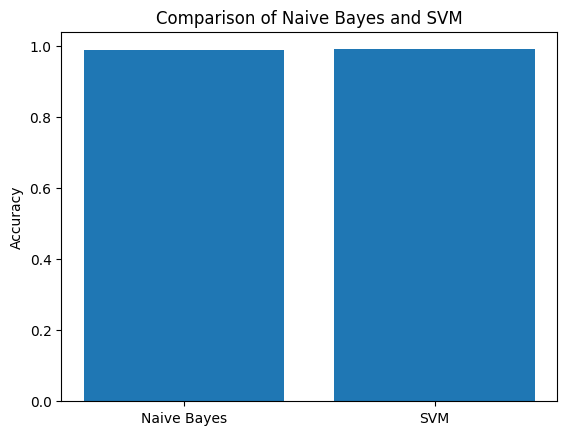

In [39]:
plt.bar(['Naive Bayes', 'SVM'], [nb_accuracy, svm_accuracy])
plt.ylabel('Accuracy')
plt.title('Comparison of Naive Bayes and SVM')
plt.show()

print the confusion matrix and make a simple test

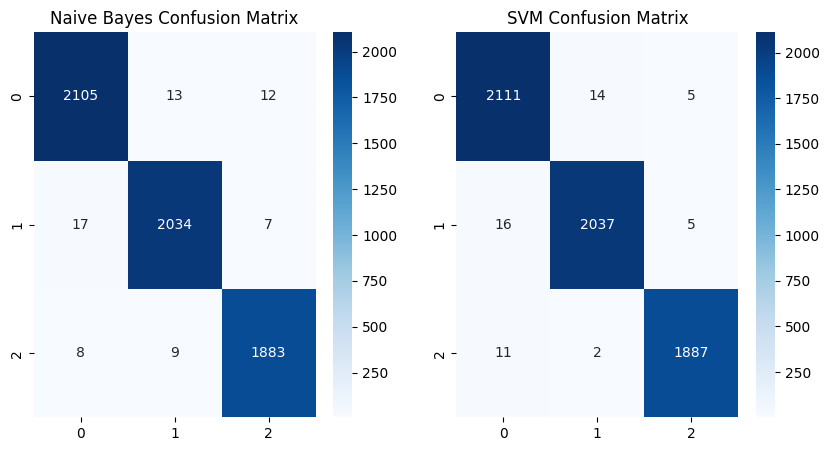

Naive Bayes Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2130
           1       0.99      0.99      0.99      2058
           2       0.99      0.99      0.99      1900

    accuracy                           0.99      6088
   macro avg       0.99      0.99      0.99      6088
weighted avg       0.99      0.99      0.99      6088

SVM Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2130
           1       0.99      0.99      0.99      2058
           2       0.99      0.99      0.99      1900

    accuracy                           0.99      6088
   macro avg       0.99      0.99      0.99      6088
weighted avg       0.99      0.99      0.99      6088



In [50]:


nb_cm = confusion_matrix(y_test_encoded, nb_y_pred)
svm_cm = confusion_matrix(y_test_encoded, svm_y_pred)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(nb_cm, annot=True, ax=ax[0], cmap='Blues', fmt='g')
ax[0].set_title('Naive Bayes Confusion Matrix')
sns.heatmap(svm_cm, annot=True, ax=ax[1], cmap='Blues', fmt='g')
ax[1].set_title('SVM Confusion Matrix')
plt.show()

# Classification Report
print('Naive Bayes Classification Report')
print(classification_report(y_test_encoded, nb_y_pred))
print("=========================================")
print('SVM Classification Report')
print(classification_report(y_test_encoded, svm_y_pred))

In [49]:
sample_text = ["The government has announced new economic measures to boost the economy."]
sample_text = vectorizer.transform(sample_text)

nb_sample_pred = nb_model.predict(sample_text)
svm_sample_pred = svm_model.predict(sample_text)

nb_sample_pred_label = le.inverse_transform(nb_sample_pred)
svm_sample_pred_label = le.inverse_transform(svm_sample_pred)

print(f'Naive Bayes Sample Prediction: {nb_sample_pred_label[0]}')
print(f'SVM Sample Prediction: {svm_sample_pred_label[0]}')

Naive Bayes Sample Prediction: economy
SVM Sample Prediction: economy
